In [1]:
from binance.client import Client
import pandas as pd

API_KEY = ''
API_SECRET = ''
client = Client(API_KEY, API_SECRET)

In [2]:
candlesticks = client.get_historical_klines("XRPUSDT", Client.KLINE_INTERVAL_5MINUTE, '1 months')#"31 Aug, 2021", "1 Sep, 2021")

In [3]:
def binanceDataFrame(klines):
    df = pd.DataFrame(klines,dtype=float, columns = ('Open Time',
                                                                    'open',
                                                                    'high',
                                                                    'low',
                                                                    'close',
                                                                    'volume',
                                                                    'Close time',
                                                                    'Quote asset volume',
                                                                    'Number of trades',
                                                                    'Taker buy base asset volume',
                                                                    'Taker buy quote asset volume',
                                                                    'Ignore'))

    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df = df.set_index('Open Time')
    
    return df

In [4]:
df = binanceDataFrame(candlesticks)

In [5]:
df.to_csv("xrp_3years_5min.csv")

In [6]:
from ta import add_all_ta_features

In [7]:
# df = add_all_ta_features(
#     df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

In [8]:

import backtrader as bt
import backtrader.indicators as btind


In [9]:
import backtrader as bt
import datetime as dt


# #Instantiate Cerebro engine
# cerebro = bt.Cerebro()

# #Add data feed to Cerebro
data = bt.feeds.PandasData(dataname=df)
# cerebro.adddata(data)
# cerebro.broker.setcash(cash=100)

# cerebro.addsizer(bt.sizers.PercentSizer)

# cerebro.addstrategy(MAcrossover)
# # Add the analyzers we are interested in
# cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
# cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")

# #Run Cerebro Engine
# strategies = cerebro.run()
# firstStrat = strategies[0]
# cerebro.plot()

In [10]:
# printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())

In [11]:
def printTradeAnalysis(cerebro, analyzers):
    print('Backtesting Results')
    if hasattr(analyzers, 'ta'):
        ta = analyzers.ta.get_analysis()

        openTotal         = ta.total.open          
        closedTotal       = ta.total.closed        
        wonTotal          = ta.won.total           
        lostTotal         = ta.lost.total          

        streakWonLongest  = ta.streak.won.longest  
        streakLostLongest = ta.streak.lost.longest 

        pnlNetTotal       = ta.pnl.net.total       
        pnlNetAverage     = ta.pnl.net.average     

        print('Open Positions', openTotal  )
        print('Closed Trades',  closedTotal)
        print('Winning Trades', wonTotal   )
        print('Loosing Trades', lostTotal  )
       

        print('Longest Winning Streak',   streakWonLongest )
        print('Longest Loosing Streak',   streakLostLongest)
        print('Strike Rate (Win/closed)', (wonTotal / closedTotal) * 100 if wonTotal and closedTotal else 0)
        

#         print(format, 'Inital Portfolio Value', '${}'.format(100))
        print( 'Final Portfolio Value',  '${}'.format(cerebro.broker.getvalue()))
        print( 'Net P/L',                '${}'.format(round(pnlNetTotal,   2)) )
        print( 'P/L Average per trade',  '${}'.format(round(pnlNetAverage, 2)))
        print('\n')

    if hasattr(analyzers, 'drawdown'):
        print('Drawdown', '${}'.format(analyzers.drawdown.get_analysis()['drawdown']))
    if hasattr(analyzers, 'sharpe'):
        print( 'Sharpe Ratio:', analyzers.sharpe.get_analysis()['sharperatio'])
    if print(analyzers, 'vwr'):
        print( 'VRW', analyzers.vwr.get_analysis()['vwr'])
    if hasattr(analyzers, 'sqn'):
        print( 'SQN', analyzers.sqn.get_analysis()['sqn'])
    print('\n')

    print('Transactions')
    print( 'Date', 'Amount', 'Price', 'SID', 'Symbol', 'Value')
    for key, value in analyzers.txn.get_analysis().items():
        print( key.strftime("%Y/%m/%d %H:%M:%S"), value[0][0], value[0][1], value[0][2], value[0][3], value[0][4])



In [12]:
"""
Defines class / functions tools for strategies.
"""
import backtrader as bt


class VolumeWeightedAveragePrice(bt.Indicator):

    plotinfo = dict(subplot=False)

    params = (("period", 360),)

    alias = (
        "VWAP",
        "VolumeWeightedAveragePrice",
    )
    lines = ("VWAP",)
    plotlines = dict(VWAP=dict(alpha=1, linestyle="-", linewidth=2.0))

    def __init__(self):
        # Before super to ensure mixins (right-hand side in subclassing)
        # can see the assignment operation and operate on the line
        cumvol = bt.ind.SumN(self.data.volume, period=self.p.period)
        typprice = (
            (self.data.close + self.data.high + self.data.low) / 3
        ) * self.data.volume
        cumtypprice = bt.ind.SumN(typprice, period=self.p.period)
        self.lines[0] = cumtypprice / cumvol

        super(VolumeWeightedAveragePrice, self).__init__()

In [13]:

class firstStrategy(bt.Strategy):
    params = (
        ('rsi_period',5),
        ('ema_period',100),
        ('stop_loss',1),
        ('take_profit',1),
        ("period1", 2),
        ("devfactor", 2),
        ("rsip", 8),
        ("buy_price_adjust", 0.0),
        ("buy_limit_adjust", 0.00),
        ("buy_stop_adjust", 0.02),
        ("maperiod", 15), 
        ("kvwap", 0.01),
        
         ('stopLoss', 0.01), #if current price is %40 below the original buy price then sell the stock
        ('stopWin',0.015) #if current price is %40 above the original buy price then sell the stock
    )
    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.ema3 = bt.indicators.EMA(self.data.close, period=self.params.ema_period) 
        self.ema2 = bt.indicators.EMA(self.data.close, period=50) 
        self.ema1 = bt.indicators.EMA(self.data.close, period=21) 

        self.o_li = list()

        # To keep track of pending orders
        self.order = None  
        self.stopOrder = None
        self.vwap = VolumeWeightedAveragePrice(
            self.datas[0], period=self.params.maperiod
        )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash

        if order.status in [order.Completed]:
#             if order.isbuy():
#                 self.log(f'BUY EXECUTED, {order.executed.price:.5f}')
# #                 stop_price = order.executed.price * (1.0 - self.params.stop_loss)
# #                 self.sell(exectype=bt.Order.Stop, price=stop_price)
#             elif order.issell():
#                 self.log(f'SELL EXECUTED, {order.executed.price:.5f}')
#                 self.log
            self.bar_executed = len(self)

    def notify_timer(self, timer, when, *args, **kwargs):
        self.vwap_period = 1
        
    def next(self):

        if not self.position:
            if self.rsi<30 and self.data.close>self.ema2:
                size = 1000/self.datas[0].close[0]

                self.order = self.buy(price=(self.datas[0].close[0]),exectype=bt.Order.Market,size=size)
#             if self.rsi>70 and self.order.Completed:
#                 self.order = self.sell(price=(self.datas[0].close[0]),exectype=bt.Order.Market,size=1000)

        else:
            if self.order and (self.data.close - self.order.price)!=0.0:
                change = (self.data.close - self.order.price)/self.order.price
                if change>0.01 or change<-0.01:
                    print("selling at change:", change)
                    self.sell()



In [14]:
import backtrader as bt
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
# ======================================================================================================================
# MAIN
# ======================================================================================================================

# Create an instance of cerebro
cerebro = bt.Cerebro(stdstats=False)

# Be selective about what we chart
#cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)

# Set the investment capital
cerebro.broker.setcash(2000)
cerebro.broker.setcommission(.001)

# Set position size
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

# Add our strategy
cerebro.addstrategy(firstStrategy)
# cerebro.optstrategy(firstStrategy, rsi_period=6)

cerebro.adddata(data)


# Add analyzers
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0, annualize=True, timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.VWR, _name='vwr')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='txn')
# Run our Backtest
backtest = cerebro.run()
backtest_results = backtest[0]




Loading BokehJS ...

selling at change: 0.01308804686069923
2021-08-27T10:15:00, OPERATION PROFIT, GROSS 13.18, NET 11.17
selling at change: 0.012061982743440787
2021-08-27T20:30:00, OPERATION PROFIT, GROSS 12.24, NET 10.23
selling at change: 0.012040887040886869
2021-08-27T23:00:00, OPERATION PROFIT, GROSS 12.04, NET 10.03
selling at change: -0.010705182667799443
2021-08-28T02:40:00, OPERATION PROFIT, GROSS -10.62, NET -12.61
selling at change: -0.010892116182572565
2021-08-29T03:05:00, OPERATION PROFIT, GROSS -11.32, NET -13.31
selling at change: -0.01040943789035393
2021-08-30T00:00:00, OPERATION PROFIT, GROSS -10.41, NET -12.40
selling at change: -0.011046770601336273
2021-08-31T06:40:00, OPERATION PROFIT, GROSS -10.96, NET -12.95
selling at change: -0.011420353607985658
2021-08-31T17:35:00, OPERATION PROFIT, GROSS -11.67, NET -13.66
selling at change: 0.01242030305539447
2021-09-01T22:05:00, OPERATION PROFIT, GROSS 12.59, NET 10.57
selling at change: 0.01091668004495108
2021-09-02T07:05:00, OPERATION 

<IPython.core.display.Javascript object>


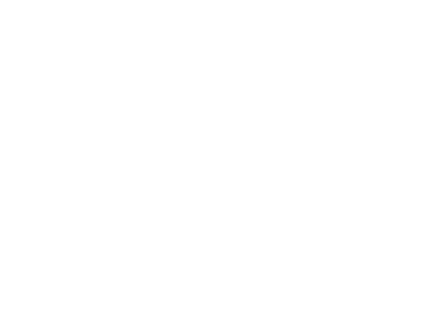

In [15]:
figure = cerebro.plot(style ='candlebars')[0][0]
figure.savefig('example.png')

In [ ]:
printTradeAnalysis(cerebro,backtest_results.analyzers)

]]

In [ ]:
x